In [1]:
import pandas as pd
import numpy as np
from functools import reduce
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [2]:
Topt_obs_filename = '/Users/hzc/data/LP/Topt_0709_FLUX_check.csv'
Tmax_filename = '/Users/hzc/data/LP/0709_95GPP_Tmax.csv'
Tmin_filename = '/Users/hzc/data/LP/0709_95GPP_Tmin.csv'
FLUXinfo_filename = '/Users/hzc/data/LP/FLUXNET-data-availability-20220921205702.xlsx'

Topt_model_filename = '/Users/hzc/data/MoreAnalysis_2024/Model_revised/output/01Oct24_Canopy_defaultLAI.csv'
Topt_NoAccl_filename = '/Users/hzc/data/sobol_sensitivity_test/OnServer/Output/27May24_Canopy_defaultLAI_noAccl_noAdapt.csv'

In [3]:
Topt_obs = pd.read_csv(Topt_obs_filename, index_col = 0)
Tmax = pd.read_csv(Tmax_filename, index_col = 0)
Tmin = pd.read_csv(Tmin_filename, index_col = 0)
flx = pd.read_excel(FLUXinfo_filename,
                    sheet_name = "merged",index_col = 'site')
Topt_model = pd.read_csv(Topt_model_filename, index_col = 0)
Topt_NoAccl = pd.read_csv(Topt_NoAccl_filename, index_col = 0)
flx.loc[flx['vegtype']=='WSA','vegtype'] = 'SAV'
flx.loc[flx['vegtype']=='OSH','vegtype'] = 'SHR'
flx.loc[flx['vegtype']=='CSH','vegtype'] = 'SHR'

In [4]:
# calculate average of each site
Topt_obs['Topt_obs_mean'] = Topt_obs.mean(axis=1)
Topt_obs['Topt_obs_sd'] = Topt_obs.std(axis=1)
Topt_model['Topt_model_mean'] = Topt_model.mean(axis=1)
Tmax['Tmax_mean'] = Tmax.mean(axis=1)
Tmin['Tmin_mean'] = Tmin.mean(axis=1)
Topt_NoAccl['Topt_NoAccl_mean'] = Topt_NoAccl.mean(axis=1)

In [5]:
# merge
dfs = [Topt_obs['Topt_obs_mean'],
        Topt_model['Topt_model_mean'],
        Topt_obs['Topt_obs_sd'],
        flx['vegtype'],
        Tmax[['Tmax_mean']],
        Tmin[['Tmin_mean']],
        ]
df = reduce(lambda x, y: pd.merge(x, y, on="site", how="inner"), dfs)
df = df.dropna(axis='index',how="any") 
df['Tmin_err'] = df['Topt_obs_mean'] - df['Tmin_mean']
df['Tmax_err'] = df['Tmax_mean'] - df['Topt_obs_mean']

In [6]:
# df.sort_values(by="Topt_obs_mean",ascending=False)

In [7]:
# merge Topt_obs & Topt_NoAccl
dfs = [Topt_obs[['Topt_obs_mean']],
        Topt_NoAccl[['Topt_NoAccl_mean']],
        ]
df_noAccl = reduce(lambda x, y: pd.merge(x, y, on="site", how="inner"), dfs)
df_noAccl = df_noAccl.dropna(axis='index',how="any") 

In [8]:
# OLS regression: default model
X = sm.add_constant(df['Topt_model_mean'])
model = sm.OLS(df['Topt_obs_mean'], X)
results = model.fit()
R2 = round(results.rsquared,2)
coef_df = pd.DataFrame({"params": results.params,   # coefficients
                        "t": round(results.tvalues,3),       # t-value
                        "p-values": round(results.pvalues,4) # p-value
                         })
coef_df[['coef_0.025','coef_0.975']] = results.conf_int() # confidence interval
rmse = ((df['Topt_obs_mean']-results.fittedvalues)**2).mean()**0.5
print(coef_df)
print(R2, rmse)

                   params       t  p-values  coef_0.025  coef_0.975
const           -3.081898  -1.417    0.1601   -7.405686    1.241890
Topt_model_mean  1.194636  12.888    0.0000    1.010306    1.378966
0.66 2.7160246131645716


In [9]:
# OLS regression: default model
X = sm.add_constant(df_noAccl['Topt_NoAccl_mean'])
model_2 = sm.OLS(df_noAccl['Topt_obs_mean'], X)
results_2 = model_2.fit()
R2_2 = round(results_2.rsquared,2)
coef_df_2 = pd.DataFrame({"params": results_2.params,   # coefficients
                        "t": round(results_2.tvalues,3),       # t-value
                        "p-values": round(results_2.pvalues,4) # p-value
                         })
coef_df_2[['coef_0.025','coef_0.975']] = results_2.conf_int() # confidence interval
rmse_2 = ((df_noAccl['Topt_obs_mean']-results_2.fittedvalues)**2).mean()**0.5
print(coef_df_2)
print(R2_2, rmse)

                    params       t  p-values  coef_0.025  coef_0.975
const            -7.640378  -2.822     0.006  -13.024340   -2.256415
Topt_NoAccl_mean  1.333152  12.016     0.000    1.112529    1.553776
0.63 2.7160246131645716


In [10]:
# predict
predictX = np.arange(6,35,2)
predictY = results.predict(sm.add_constant(predictX))
predictY_noAccl = results_2.predict(sm.add_constant(predictX))

In [11]:
# set labels
str1 = 'With thermal adjustments\n'+\
        '(slope = %.2f$\pm$%.2f, '%(coef_df.loc['Topt_model_mean','params'],
                                  coef_df.loc['Topt_model_mean','params'] - coef_df.loc['Topt_model_mean','coef_0.025']) + \
       '$R^{2}$=%.2f)'%R2

str2 = 'Without thermal adjustments\n'+\
        '(slope = %.2f$\pm$%.2f, '%(coef_df_2.loc['Topt_NoAccl_mean','params'],
                                  coef_df_2.loc['Topt_NoAccl_mean','params'] - coef_df_2.loc['Topt_NoAccl_mean','coef_0.025']) + \
       '$R^{2}$=%.2f)'%R2_2
print(str1, str2)

With thermal adjustments
(slope = 1.19$\pm$0.18, $R^{2}$=0.66) Without thermal adjustments
(slope = 1.33$\pm$0.22, $R^{2}$=0.63)


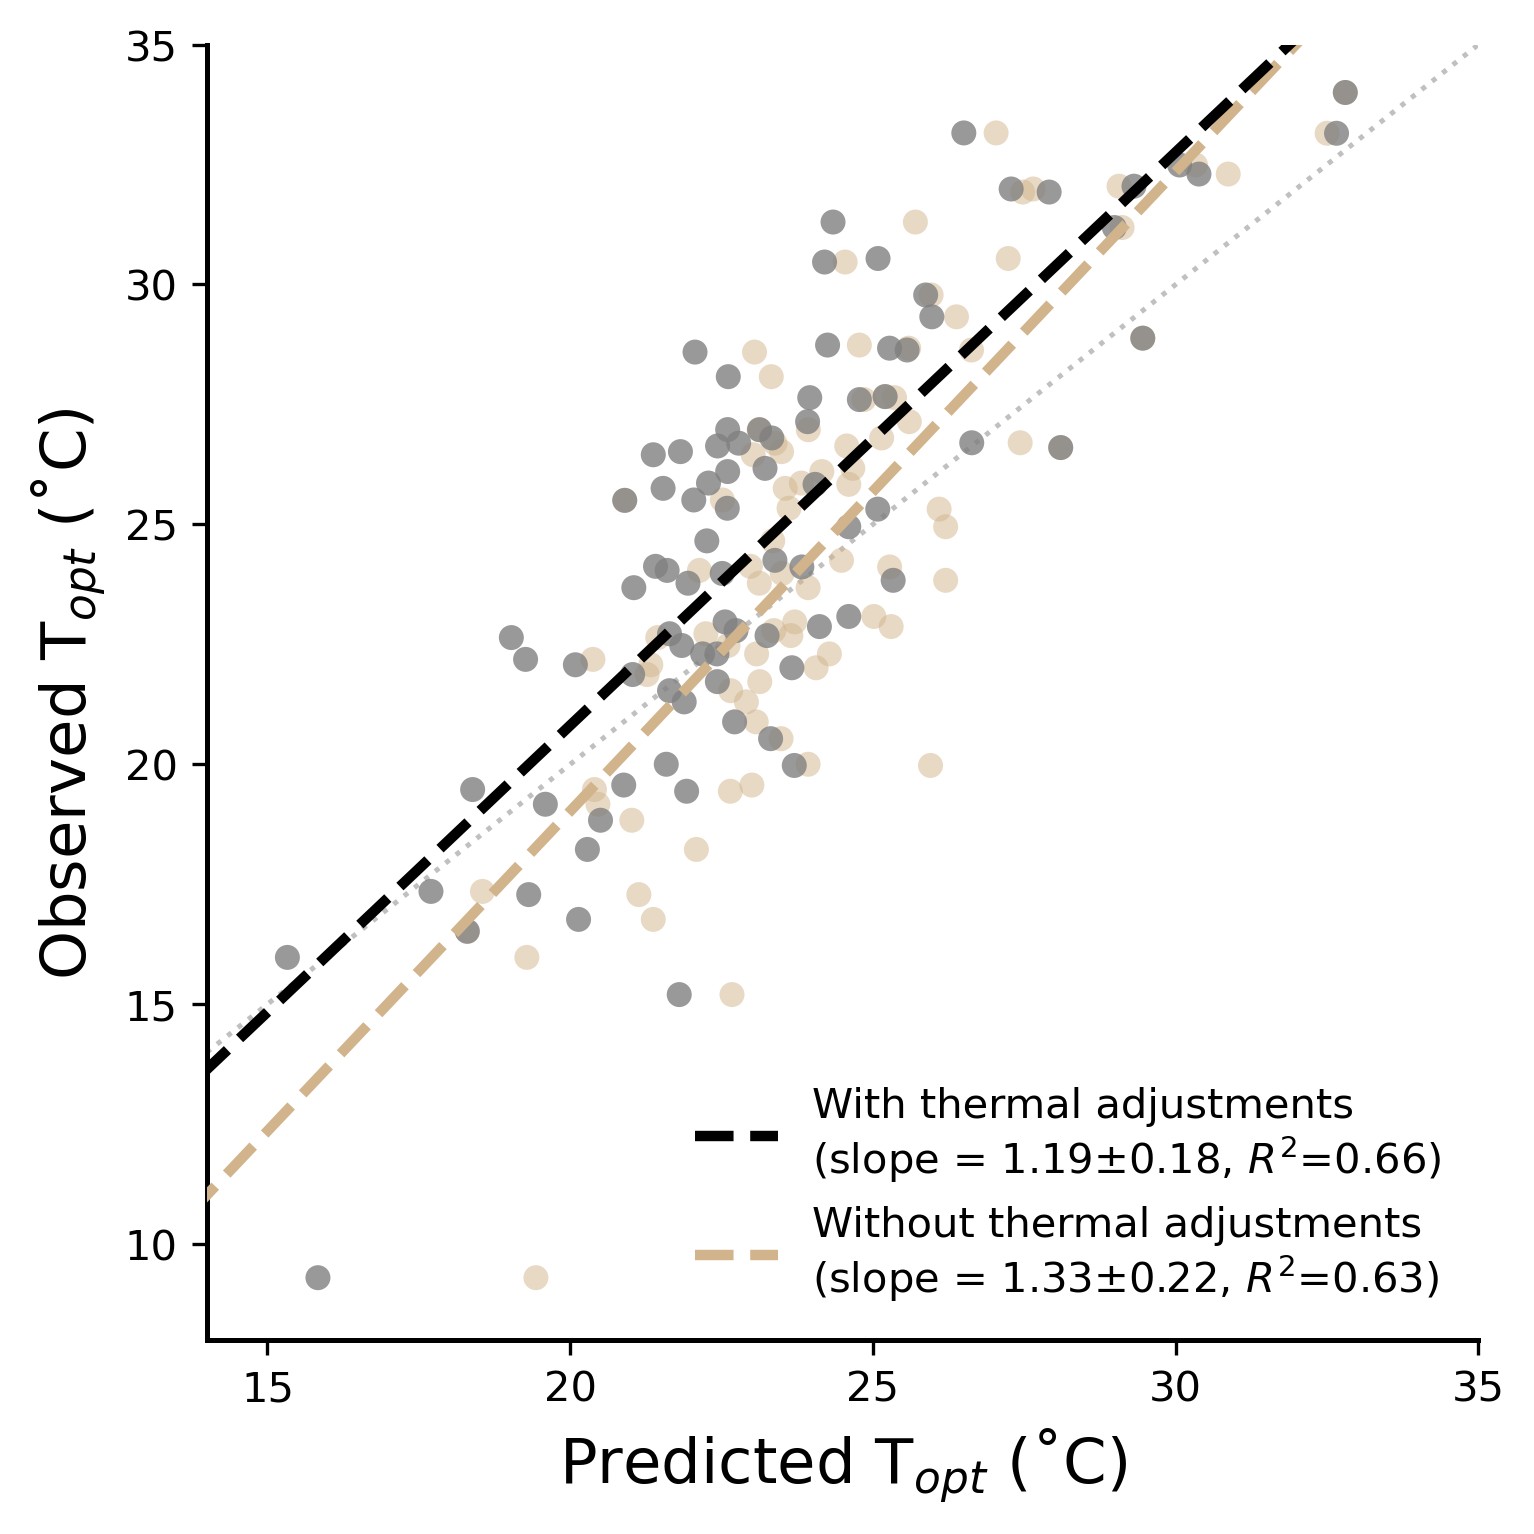

In [12]:
# plot
fig, ax = plt.subplots(figsize=(5, 5),
                       dpi=300,
                       layout='constrained')
ax.scatter(df['Topt_model_mean'], df['Topt_obs_mean'],
           zorder=3,
           color='grey',
           edgecolors='none',
           alpha=.8)
ax.scatter(df_noAccl['Topt_NoAccl_mean'], df_noAccl['Topt_obs_mean'],
           zorder=2,
           color='tan',
           edgecolors='none',
           alpha=.5)
ax.errorbar(df['Topt_model_mean'], df['Topt_obs_mean'],
        #     yerr=df['Topt_obs_sd'],
                # yerr = df[['Tmin_err','Tmax_err']].transpose(),
                fmt='none',
                capsize=3,
                lw=1.,
                color='grey',
                alpha=.3,
                zorder=1)
ax.plot(predictX, predictY,
        color='k', lw=2.5,
        linestyle='--',
        label=str1,
        zorder=5,
        )
ax.plot(predictX, predictY_noAccl,
        color='tan', lw=2.5,
        linestyle='--',
        label=str2,
        zorder=4,
        )
ax.plot([5,36],[5,36],
        linestyle=':',
        color='silver',
        lw=1.2,
        zorder=0) 
ax.legend(loc='best',
          frameon=False,
          fontsize=10)
ax.set_xlim(14,35)
ax.set_ylim(8,35)
ax.set_xticks(np.arange(15,36,5))
ax.set_xlabel("Predicted T$_{opt}$ (˚C)", fontsize=15)
ax.set_ylabel("Observed T$_{opt}$ (˚C)", fontsize=15)
ax.xaxis.set_tick_params(labelsize=10)
ax.yaxis.set_tick_params(labelsize=10)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_linewidth(1.2)
ax.spines['left'].set_linewidth(1.2)

In [13]:
VEG_TYPE = ['ENF', 'EBF', 'DBF', 'MF', 'SHR', 'SAV', 'GRA', 'WET', 'CRO']
MARK_TYPE = ['o', 's', '^', 'D', 'o', 'v', 's', 'D', '^']
COLOR_TYPE = ['forestgreen', 'limegreen', 'springgreen', 'orange', 'khaki', 'lightsalmon', 'palevioletred', 'darkblue','brown']

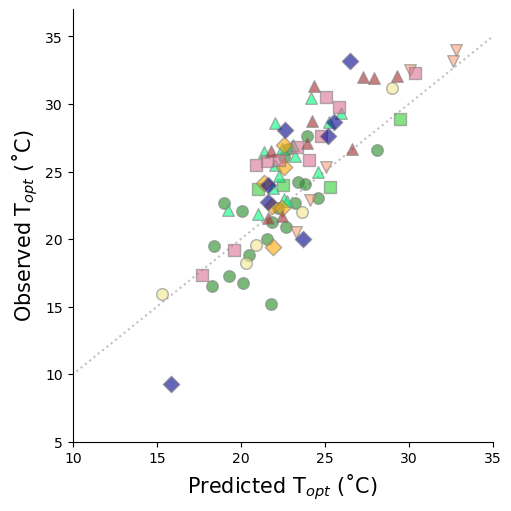

In [14]:
fig, ax = plt.subplots(figsize=(5,5),
                #        dpi=300,
                       layout='constrained')
for i in range(9):
    temp = df[df["vegtype"]==VEG_TYPE[i]]
    ax.scatter(temp["Topt_model_mean"],temp["Topt_obs_mean"],
               marker=MARK_TYPE[i],
               facecolors=COLOR_TYPE[i],
               edgecolors='grey',
               alpha=.6,
               s=70,
               label=VEG_TYPE[i]
                )
ax.plot([5,36],[5,36],
        linestyle=':',
        color='silver',
        lw=1.5,
        zorder=0) 
ax.set_xlim(10,35)
ax.set_ylim(5,37)
ax.set_xlabel("Predicted T$_{opt}$ (˚C)", fontsize=15)
ax.set_ylabel("Observed T$_{opt}$ (˚C)", fontsize=15)
ax.xaxis.set_tick_params(labelsize=10)
ax.yaxis.set_tick_params(labelsize=10)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)